<a href="https://colab.research.google.com/github/crisalex25/TFM_HydroMLGenerationOptimization/blob/main/TFM_Optimizaci%C3%B3n_de_la_generaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo de Fin de Master**
## **Máster Universitario en Inteligencia Artificial para el Sector de la Energía y las Infraestructuras**
Optimización de generación en centrales hidroeléctricas mediante técnicas de aprendizaje automático

##Optimización

Librerías

In [ ]:
!pip install deap

In [ ]:
'''
    LIBRERIAS
    ---------------------------------------------------------
'''
# Librerías de Algoritmos genéticos
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# Librerías auxiliares
import matplotlib.pyplot as plt

# Librerías auxiliares
from operator import truediv
import numpy as np
import random
import time

In [ ]:
#Registro el tiempo de inicio del programa
t0 = time.time()

Variables y parámetros

In [ ]:
numeroGenesTotal= 72
numeroCromosomas=3
numeroGenesPorCromosoma= int(numeroGenesTotal/numeroCromosomas)
probCruce=0.7            #Probabilidad de cruce
probMutacion=0.3         #Probabilidad de mutación
num_generaciones= 100    #Numero de generaciones
tamaño_poblacion = 100   #Tamaño de la población
penaliza=9999999.9

P_min_G1=400.0    #Potencia mínima que puede producir el generador 1 Papallacta
P_max_G1=1800.0   #Potencia máxima que puede producir el generador 1 Papallacta
P_max_G2=4200.0   #Potencia máxima que puede producir el generador 2 Papallacta
P_min_G2=1700.0   #Potencia mínima que puede producir el generador 2 Papallacta
P_max_G3=2100.0   #Potencia máxima que puede producir el generador 3 Loreto
P_min_G3=500.0   #Potencia mínima que puede producir el generador 3 Loreto

#Demanda de potencia energética que se debe satisfacer
demandaConsumoPorHoras_GC = [1200, 1333, 1444, 1884, 1884, 1884, 1884, 1884, 1884, 1484, 1584, 1284,
                             1684, 1784, 1684, 1114, 1284, 1384, 1884, 1884, 1884, 1884, 1884, 1700]
demandaConsumoPorHoras_AC = [4811, 4787, 4778, 4780, 4856, 4878, 4853, 4901, 5082, 5250, 5292, 5305,
                             5103, 5219, 5266, 5258, 5311, 5138, 4989, 4876, 4745, 4876, 4833, 4845]
precio_energia = [6.19, 8.39, 6.19, 6.19, 5.35, 6.48, 5.35, 5.35, 6.19, 6.19, 6.19, 6.48,
                  6.19, 6.48, 6.19, 6.48, 6.19, 6.19, 9.46, 9.46, 8.96, 6.19, 6.19, 6.19]
horas = [0,1,2,3,4, 5, 6, 7, 8, 9, 10,11,12,13,14,15, 16,17,18,19,20,21,22,23]

Funciones Auxiliares

In [ ]:
#Sección que contiene funciones auxiliares propias del dominio del problema a resolver

#Función que obtiene el coste en € que correspondiente al generador diesel de producir una potencia determinada
def getCosteDiesel(potencia):
    return float((potencia) * 0.008)

#Función que obtiene el coste en € que correspondiente al generador de gas de producir una potencia determinada
def getCosteGas(potencia):
    return float(potencia * 0.0025)

#Función que obtiene el coste en € que correspondiente al generador de gas de producir una potencia determinada
def getCosteG3(potencia):
    return float(potencia * 0.0019)

#Función que muestra un gráfico con los datos de las potencias contenidas en un individuo.
def dibujarGrafico(individuo, demandaConsumoPorHoras, horas,tituloGrafico):
        individuo1 = np.zeros(numeroGenesPorCromosoma)
        for i in range(0,numeroGenesPorCromosoma):
            individuo1[i]=individuo[i] #Generador G1 Papallacta

        individuo2 = np.zeros(numeroGenesPorCromosoma)
        for i in range(0,numeroGenesPorCromosoma):
            individuo2[i]=individuo[i+numeroGenesPorCromosoma] #Generador G2 Papallacta

        individuo3 = np.zeros(numeroGenesPorCromosoma)
        for i in range(0,numeroGenesPorCromosoma):
            individuo3[i]=individuo[i+numeroGenesPorCromosoma*2] #Generador G3 Loreto

        plt.bar(horas, individuo1 + individuo2 , label='G2',color='green')
        plt.bar(horas, individuo1 , label='G1',color='blue')
        plt.plot(horas,demandaConsumoPorHoras_AC,'*--', label='Demanda AutoConsumo' )
        plt.ylabel('Potencia (Kw)')
        plt.xlabel('Horas (0 - 24)')
        plt.title(tituloGrafico)
        #agregar segundo grafico

        plt.legend(loc='best')
        plt.show()

#La función realiza varias comprobaciones para saber si un individuo es válido.
def individuoIsValid(x):

    #Elimino valores negativos
    for i in range(0,numeroGenesPorCromosoma*3):
        if (x[i] < float(0.0)):
            return False

    #El generador G1 debe generar más potencia de 400 kw para que funcione
    for i in range(0,numeroGenesPorCromosoma):
        if (x[i]>0.0 and x[i]< P_min_G1):
            return False

    #El generador G2 debe generar más potencia de 1700 kw para que funcione
    for i in range(numeroGenesPorCromosoma,numeroGenesPorCromosoma*2):
        if (x[i]>0.0 and x[i]< P_min_G2):
            return False

    #El generador G3 debe generar más potencia de 500 kw para que funcione
    for i in range(numeroGenesPorCromosoma*2,numeroGenesTotal):
        if (x[i]>0.0 and x[i]< P_min_G3):
            return False

    #Compruebo que el generador 1 solo puede tener asignada como máxima su maximo permitido
    for i in range(0,numeroGenesPorCromosoma):
        if (x[i] > P_max_G1):
            return False

    #Compruebo que el generador 2 solo puede tener asignada como máxima su maximo permitido
    for i in range(numeroGenesPorCromosoma,numeroGenesPorCromosoma*2):
       if (x[i] > P_max_G2):
            return False

    #Compruebo que el generador 3  solo puede tener asignada como máxima su maximo permitido
    for i in range(numeroGenesPorCromosoma*2,numeroGenesTotal):
       if (x[i] > P_max_G3):
            return False

    #Compruebo si el individuo satisface la demanda energética AC
    for i in range(len(demandaConsumoPorHoras_AC)):
        demandaAsatistacer_AC = float(demandaConsumoPorHoras_AC[i])
        diferencia= demandaAsatistacer_AC - float(x[i]) - float(x[i+numeroGenesPorCromosoma])
        if (diferencia > 0.0):
            return False
    return True

    #Compruebo si el individuo satisface la demanda energética GC
    for i in range(len(demandaConsumoPorHoras_GC)):
        demandaAsatistacer_GC = float(demandaConsumoPorHoras_GC[i])
        diferencia= demandaAsatistacer_GC - float(x[i+numeroGenesPorCromosoma*2])
        if (diferencia > 0.0):
            return False
    return True


FUnciones Auxiliares

In [ ]:
'''
    FUNCIONES AUXILIARES DEL AG
    ---------------------------------------------------------
'''
# Función para la creación de individuos iniciales
def crea_individuo():   # Creación de individuos iniciales
    cromosoma = np.zeros(numeroGenesTotal)

    # Asigno potencias aleatoriamente para el generador diesel
    for i in range(0,numeroGenesPorCromosoma):
        cromosoma[i] =float(np.random.uniform(P_min_G1, P_max_G1) )

    # Asigno potencias aleatoriamente para el generador de gas
    for i in range(numeroGenesPorCromosoma, numeroGenesPorCromosoma*2):
        cromosoma[i] =float(np.random.uniform(P_min_G2, P_max_G2) )

    # Asigno potencias aleatoriamente para el generador de gas
    for i in range(numeroGenesPorCromosoma*2, numeroGenesPorCromosoma*3):
        cromosoma[i] =float(np.random.uniform(P_min_G2, P_max_G2) )

    #Formateo los valores del cromosoma a decimal con 2 decimales
    for i in range(0, numeroGenesPorCromosoma*3):
        cromosoma[i] = float("{:.2f}".format(cromosoma[i]))  #Doy formato al valor

    return cromosoma


#Función que aplica el operador de mutación para un indivudo dado
def mutacion(individuo):
    #Compruebo que al hacer los operadores de cruce no hay numeros negativos
    if (individuoIsValid(individuo) == False):
        return individuo,  #Individuo no válido así que no aplico mutacion

    #Decido el gen que se va modificar
    random_gen_a_modificar = random.randint(0, numeroGenesTotal-1)

    #Modifico la potencia del gen seleccionado
    random_pot = random.randint(0, int(abs(individuo[random_gen_a_modificar])))

    #Una vez que tengo la potencia a modificar y el gen que voy a modificar, decido aleatoriamente si voy a sumar o restar la potencia calculada
    cromosoma_a_modificar = random.randint(0, 2)
    if (cromosoma_a_modificar==0):
        individuo[random_gen_a_modificar] +=  float(random_pot)
    else:
        aux = individuo[random_gen_a_modificar] - float(random_pot)
        #Si el valor de aux es <0 igualo a 0 la variable aux ya que no es posible que tener potencias negativas
        if aux <0:
            aux=0
        individuo[random_gen_a_modificar]= aux

    #Formateo los valores del cromosoma a decimal con 2 decimales
    for i in range(numeroGenesTotal):
        individuo[i] = float("{:.2f}".format(individuo[i]))  #Doy formato al valor

    return individuo,


#Función objetivo de nuestro problema
def fitness(x):
    """
    Función objetivo del problema
    """
    coste=0.0
    isValid =individuoIsValid(x)
    if (isValid is False):
        return penaliza,

    #Coste del generador diesel
    costeGeneradorDiesel=0.0
    for i in range(0,numeroGenesPorCromosoma):
        costeGeneradorDiesel=costeGeneradorDiesel + getCosteDiesel(x[i])

    #Coste del generador diesel
    costeGeneradorGas=0.0
    for i in range(numeroGenesPorCromosoma,numeroGenesPorCromosoma*2):
        costeGeneradorGas=costeGeneradorGas + getCosteGas(x[i])

    #Coste del generador diesel
    costeGeneradorG3=0.0
    for i in range(numeroGenesPorCromosoma*2,numeroGenesPorCromosoma*3):
        costeGeneradorG3=costeGeneradorG3 + getCosteG3(x[i])

    coste= costeGeneradorDiesel+ costeGeneradorGas + costeGeneradorG3
    coste= float("{:.2f}".format(coste))  #Doy formato al coste

    return coste,


#Función que ejecuta el algoritmo genético
def unico_objetivo_ga(c, m, toolbox):  #c=> probabilidad de cruce y m => probabilidad de mutación
    NGEN = num_generaciones #Numero de generaciones
    MU = tamaño_poblacion  #Tamaño de la población
    LAMBDA = MU  # Número de descendientes de la población
    CXPB = c
    MUTPB = m

    pop = toolbox.ini_poblacion(n = MU)
    hof = tools.HallOfFame(1, similar = np.array_equal)

    stats = tools.Statistics(key = lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()

    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats= stats, halloffame=hof, verbose = False)
    return pop, hof, logbook

Configuración del Algoritmo Genético

In [ ]:
'''
    CONFIGURACION DEL AG PROPORCIONADO POR LA LIBRERIA DEAP
    ---------------------------------------------------------
'''
creator.create("FitnessMin", base.Fitness, weights = (-1,))
creator.create("Individual", np.ndarray, fitness = creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, crea_individuo)
toolbox.register("ini_poblacion", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)       #Indica cual es la función objetivo
toolbox.register("mate", tools.cxOnePoint)  #Configuración del operador de cruce por 1 punto
toolbox.register("mutate", mutacion)        #Indica cual es la función de mutación
toolbox.register("select", tools.selTournament, tournsize = 3)  #Indica que el operador de selección es del tipo torneo

pop_new, pareto_new, log = unico_objetivo_ga(probCruce,probMutacion, toolbox)
t1 = time.time()
segundos = int(t1-t0)

Resultados

Tiempo empleado:  1  segundos
La mejor solución es:  [1325.62 1231.31 1531.26  436.71  876.9  1392.77 1390.27  844.23  790.77
 1458.33  998.3  1341.54  852.06 1640.94 1350.27 1000.92 1473.49  693.52
  996.68 1530.22 1595.17  665.85 1543.82  452.44 4028.14 3652.3  2881.78
 2852.07 3229.05 1789.39 3865.5  1926.44 3348.38 3052.43 3403.7  3409.14
 2965.43 3403.42 1996.53 1836.92 3697.52 1967.18 3112.39 3746.8  1930.26
 1993.49 1957.23 2843.89 2563.94 2946.77 2884.59 2464.5  2395.01 1859.39
 2347.45 3229.76 4000.7  3830.75 2294.62 1780.88 3151.07 3843.98 2166.98
 2133.7  2944.35 1824.73 3543.23 2070.98 2025.91 3743.27 4150.75 3040.  ]    fitness:  (9999999.9,)


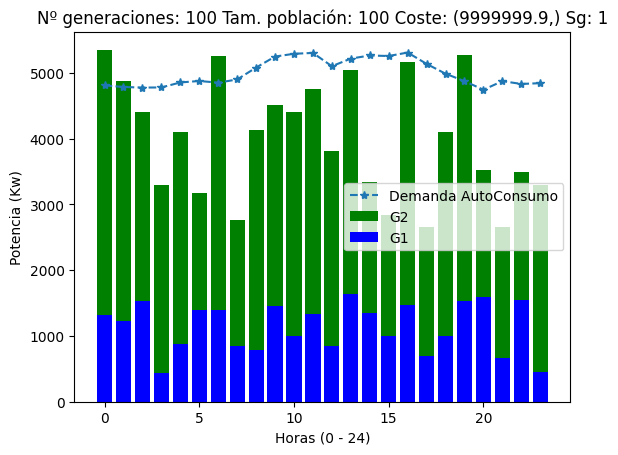

In [ ]:
'''
    RESULTADOS
    ---------------------------------------------------------
'''
#Ejecuto funciones para mostrar el resultado de la ejecución
print("Tiempo empleado: ", segundos ," segundos")
print("La mejor solución es: ", pareto_new[0],"   fitness: " , fitness(pareto_new[0]))

tituloGrafico= "Nº generaciones: "+ str(num_generaciones) + " Tam. población: "+ str(tamaño_poblacion) + " Coste: " +str(fitness(pareto_new[0]) )+" Sg: " + str(segundos)
dibujarGrafico(pareto_new[0], demandaConsumoPorHoras_AC, horas,tituloGrafico)

In [ ]:
print("   Hora   |  Demanda AC |    U1   |    U2   |  Demanda GC  |   U3   ")
print("-" * 69)

for i in range(len(demandaConsumoPorHoras_AC)):
    print(f"{i:^9} | {demandaConsumoPorHoras_AC[i]:^11} | {pareto_new[0][i]:^7.2f} | {pareto_new[0][i+24]:^7.2f} | {demandaConsumoPorHoras_GC[i]:^12} | {pareto_new[0][i+48]:^7.2f}")


   Hora   |  Demanda AC |    U1   |    U2   |  Demanda GC  |   U3   
---------------------------------------------------------------------
    0     |    4811     | 1325.62 | 4028.14 |     1200     | 2563.94
    1     |    4787     | 1231.31 | 3652.30 |     1333     | 2946.77
    2     |    4778     | 1531.26 | 2881.78 |     1444     | 2884.59
    3     |    4780     | 436.71  | 2852.07 |     1884     | 2464.50
    4     |    4856     | 876.90  | 3229.05 |     1884     | 2395.01
    5     |    4878     | 1392.77 | 1789.39 |     1884     | 1859.39
    6     |    4853     | 1390.27 | 3865.50 |     1884     | 2347.45
    7     |    4901     | 844.23  | 1926.44 |     1884     | 3229.76
    8     |    5082     | 790.77  | 3348.38 |     1884     | 4000.70
    9     |    5250     | 1458.33 | 3052.43 |     1484     | 3830.75
   10     |    5292     | 998.30  | 3403.70 |     1584     | 2294.62
   11     |    5305     | 1341.54 | 3409.14 |     1284     | 1780.88
   12     |    5103     | 852.06 

#Optimización Central Loreto

##Algoritmo Genético


In [5]:
import random
from tabulate import tabulate

## Definición de funciones

# Función para calcular los caudales turbinados y disponibles
def calcular_caudales(potencia_unit3):
    caudal_turbinado = 0.0005 * potencia_unit3 - 0.0154
    caudal_turbinado = round(caudal_turbinado, 2)
    caudal_disponible = 0.5 + 0.4
    return caudal_turbinado, caudal_disponible

# Función para calcular el costo del déficit de generación
def calcular_costo_deficit(generacion, demanda, costo_horario):
    deficit = generacion - demanda
    if deficit < 0:
        costo_deficit = abs(deficit) * costo_horario / 100
    else:
        costo_deficit = 0

    costo_deficit = round(costo_deficit, 2)
    return costo_deficit

# Función para generar una solución inicial de generación
def generar_solucion_inicial(capacidad_unit3, rango_horario):
    generacion_inicial = []
    for hora in rango_horario:
        # Generar una potencia aleatoria entre 500 y la capacidad máxima
        potencia_unit3 = max(random.uniform(0, capacidad_unit3), 500)

        caudal_turbinado, caudal_aporte_disponible = calcular_caudales(potencia_unit3)

        while caudal_turbinado > caudal_aporte_disponible:
            potencia_unit3 = max(random.uniform(0, capacidad_unit3), 500)
            caudal_turbinado, caudal_aporte_disponible = calcular_caudales(potencia_unit3)

        generacion_inicial.append(potencia_unit3)

    return generacion_inicial

# Función para generar una población inicial de soluciones de generación
def generar_poblacion_inicial(capacidad_unit3, rango_horario, tam_poblacion):
    poblacion = []
    for _ in range(tam_poblacion):
        individuo = generar_solucion_inicial(capacidad_unit3, rango_horario)
        poblacion.append(individuo)
    return poblacion

# Función para realizar el crossover entre dos individuos
def crossover(padre1, padre2):
    punto_corte = random.choice(range(len(padre1)))
    hijo2 = [padre2[i] if i < punto_corte else padre1[i] for i in range(len(padre1))]
    return hijo2

# Función para aplicar mutación a un individuo
def mutacion(individuo, prob_mutacion, capacidad_unit3):
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:
            nueva_potencia_unit3 = max(random.uniform(0, capacidad_unit3), 500)

            caudal_turbinado, caudal_aporte_disponible = calcular_caudales(nueva_potencia_unit3)

            while caudal_turbinado > caudal_aporte_disponible:
                nueva_potencia_unit3 = max(random.uniform(0, capacidad_unit3), 500)
                caudal_turbinado, caudal_aporte_disponible = calcular_caudales(nueva_potencia_unit3)

            individuo[i] = nueva_potencia_unit3
    return individuo

# Función principal para aplicar el algoritmo genético
def aplicar_algoritmo_genetico(capacidad_unit3, demanda_energia, costo_horario, rango_horario, tam_poblacion, prob_crossover, prob_mutacion, num_generaciones):
    poblacion = generar_poblacion_inicial(capacidad_unit3, rango_horario, tam_poblacion)

    for _ in range(num_generaciones):
        costos = []

        for generacion in poblacion:
            costo_generacion = sum(
                calcular_costo_deficit(
                    generacion[i], demanda_energia[i], costo_horario[i]
                )
                for i in range(len(rango_horario))
            )
            costos.append(costo_generacion)

        idx_mejor = min(range(len(costos)), key=lambda k: costos[k])
        padre = poblacion[idx_mejor]

        hijo = crossover(padre, padre)

        hijo_mutado = mutacion(hijo, prob_mutacion, capacidad_unit3)

        idx_peor = max(range(len(costos)), key=lambda k: costos[k])
        poblacion[idx_peor] = hijo_mutado

    mejor_idx = min(range(len(costos)), key=lambda k: costos[k])
    mejor_generacion = poblacion[mejor_idx]
    mejor_costo_deficit = costos[mejor_idx]

    return mejor_generacion, mejor_costo_deficit





In [6]:
# Definición de variables y parámetros
rango_horario = range(24)
capacidad_unit3 = 2150
costo_horario = [6.19, 8.39, 6.19, 6.19, 5.35, 6.48, 5.35, 5.35, 6.19, 6.19, 6.19, 6.48,
                  6.19, 6.48, 6.19, 6.48, 6.19, 6.19, 9.46, 9.46, 8.96, 6.19, 6.19, 6.19]

demanda_gc = [2114, 2175, 2095, 2248, 2213, 2170, 2172, 2286, 2289, 2213, 2181, 2303,
              2374, 2332, 2200, 2264, 2251, 2162, 2261, 2120, 2028, 2136, 2183, 2198]

tam_poblacion = 1000
prob_crossover = 0.8
prob_mutacion = 0.1
num_generaciones = 1000

# Aplicar el algoritmo genético
mejor_generacion, mejor_costo_deficit = aplicar_algoritmo_genetico(
    capacidad_unit3,
    demanda_gc,
    costo_horario,
    rango_horario,
    tam_poblacion,
    prob_crossover,
    prob_mutacion,
    num_generaciones,
)

In [7]:
# Crear tabla de resultados
tabla_resultados = []
for hora, generacion in enumerate(mejor_generacion):
    caudal_turbinado, caudal_disponible = calcular_caudales(generacion)
    costo_deficit = calcular_costo_deficit(
        generacion, demanda_gc[hora], costo_horario[hora]
    )  # Utilizar el costo_horario correspondiente a esta hora
    fila = [
        hora,
        demanda_gc[hora],
        generacion,
        caudal_turbinado,
        caudal_disponible,
        costo_deficit,
        costo_horario[hora]
    ]
    tabla_resultados.append(fila)

# Mostrar tabla de resultados
headers = ["Hora", "Demanda", "Generación U3", "Caudal Turb", "Caudal Disp", "Costo Total Défic", "Precio kwh ctvs ", ]
tabla = tabulate(tabla_resultados, headers, tablefmt="grid")
print(tabla)

# Calcular el costo total del déficit acumulado
costo_total_deficit = sum(row[5] for row in tabla_resultados)

# Mostrar el costo total del déficit acumulado
print("\nCosto total del déficit acumulado: ${:.2f}".format(costo_total_deficit))

+--------+-----------+-----------------+---------------+---------------+---------------------+--------------------+
|   Hora |   Demanda |   Generación U3 |   Caudal Turb |   Caudal Disp |   Costo Total Défic |   Precio kwh ctvs  |
+========+===========+=================+===============+===============+=====================+====================+
|      0 |      2114 |         1642.4  |          0.81 |           0.9 |               29.19 |               6.19 |
+--------+-----------+-----------------+---------------+---------------+---------------------+--------------------+
|      1 |      2175 |         1685.02 |          0.83 |           0.9 |               41.11 |               8.39 |
+--------+-----------+-----------------+---------------+---------------+---------------------+--------------------+
|      2 |      2095 |         1664.89 |          0.82 |           0.9 |               26.62 |               6.19 |
+--------+-----------+-----------------+---------------+---------------+

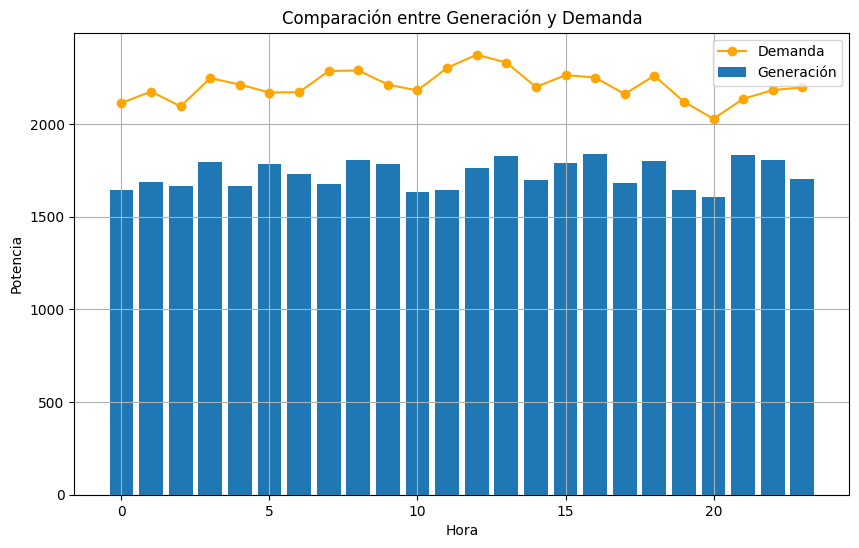

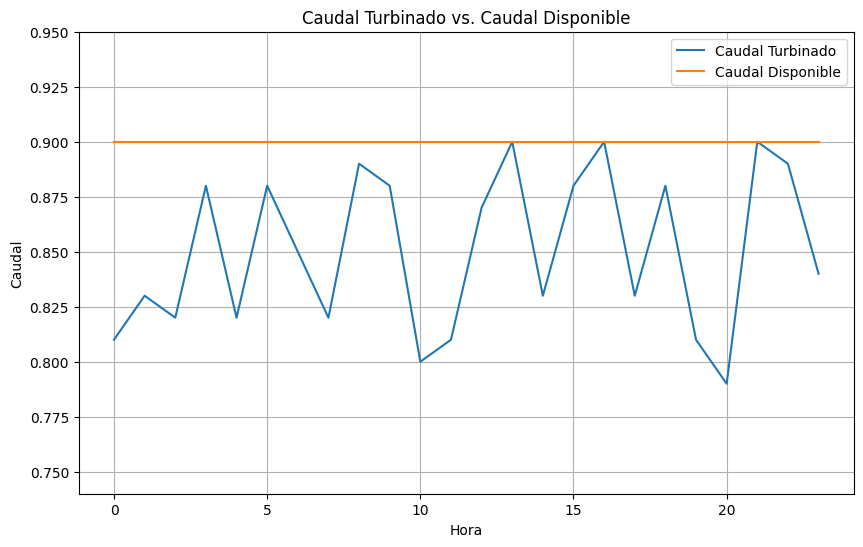

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar la comparación entre generación y demanda en forma de barras
def graficar_generacion_vs_demanda(rango_horario, generacion, demanda):
    plt.figure(figsize=(10, 6))
    plt.bar(rango_horario, generacion, label='Generación')
    plt.plot(rango_horario, demanda, label='Demanda', marker='o', color='orange')
    plt.xlabel('Hora')
    plt.ylabel('Potencia')
    plt.title('Comparación entre Generación y Demanda')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)  # Ajustar el límite inferior del eje Y a 0
    plt.show()

# Función para graficar el caudal turbado y caudal disponible centrados
def graficar_caudales(rango_horario, caudal_turbinado, caudal_disponible):
    plt.figure(figsize=(10, 6))
    plt.plot(rango_horario, caudal_turbinado, label='Caudal Turbinado')
    plt.plot(rango_horario, caudal_disponible, label='Caudal Disponible')
    plt.xlabel('Hora')
    plt.ylabel('Caudal')
    plt.title('Caudal Turbinado vs. Caudal Disponible')
    plt.legend()
    plt.grid(True)


    # Encontrar el valor máximo entre los caudales para centrar la gráfica
    max_caudal = max(caudal_disponible)+0.05
    min_caudal = min(min(caudal_turbinado), min(caudal_disponible))-0.05
    plt.ylim(min_caudal, max_caudal)  # Ajustar los límites del eje Y
    plt.show()

# Obtener los valores de caudal turbinado y caudal disponible
caudales_turbinados = [calcular_caudales(generacion)[0] for generacion in mejor_generacion]
caudales_disponibles = [calcular_caudales(generacion)[1] for generacion in mejor_generacion]

# Convertir el rango horario en una lista para usarlo como coordenadas en la gráfica de barras
rango_horario_lista = list(rango_horario)

# Graficar la comparación entre generación y demanda en forma de barras
graficar_generacion_vs_demanda(rango_horario_lista, mejor_generacion, demanda_gc)

# Graficar el caudal turbado y caudal disponible centrados
graficar_caudales(rango_horario_lista, caudales_turbinados, caudales_disponibles)




#Optimización Central Papallacta

##Algoritmo Genético
